In [1]:
import numpy as np
from numba import jit
from numba import prange
from matplotlib import pyplot as pl
import time

In [ ]:
#define basis vectors
a1p = np.array([3./2, np.sqrt(3)/2])
a2p = np.array([-1./2, np.sqrt(3)/2])


#reciprocal basis vectors (small)
g1p = (2*np.pi/3) * np.array([3/2, np.sqrt(3)/2])
g2p = (2*np.pi/3) * np.array([-3/2, 3*np.sqrt(3)/2])


#reciprocal basis vectors (big)
h1 = (2*np.pi/3) * np.array([3,np.sqrt(3)])
h2 = (2*np.pi/3) * np.array([-3,np.sqrt(3)])

def Rot(theta):
    rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    return rot

# NN interaction
def xi_q(q):
    xi=0
    a0 = np.array([1,0])
    for nn in range(6):
        an = Rot(nn * np.pi/3)@a0
        xi += np.exp(-1j*np.inner(q, an))
    return xi

def create_bz(N0):
    dg1 = g1p/N0
    dg2 = g2p/N0
    bz = np.full((N0**2, 2), None, dtype=float)

    for mm in np.arange(N0):
        for nn in np.arange(N0):
            bz[mm+N0*nn] = dg1 * (mm) + dg2 * (nn)
    return bz


def get_mom_grid_mat(L, G1=g1p, G2=g2p):    
    dg1 = G1/L
    dg2 = G2/L
    momGrid = np.full((L, L, 2), None, dtype=float)

    for l1 in range(L):
        for l2 in range(L):
            momGrid[l1, l2] = dg1*(l1) + dg2*(l2)

    return momGrid

# pauli matrices
sigX = np.array([[0,1], [1,0]])
sigY = np.array([[0,-1j], [1j,0]])
sigZ = np.array([[1,0], [0,-1]])

sigs = np.full((2,2,3), None, dtype=complex)
sigs[:,:,0] = sigX
sigs[:,:,1] = sigY
sigs[:,:,2] = sigZ

# free dispersion (gapless for theta=pi/6, gapped otherwise)
def h_k_new(k, theta=0):
    k1 = np.inner(k, a1p)
    k2 = np.inner(k, a2p)
    k12 = np.inner(k, a1p+a2p)
    

    hx = -np.cos(k1+theta)-np.cos(k2-theta)+np.sin(k12-theta)+np.sin(theta)
    hy = np.sin(k1+theta)+np.sin(k2-theta)+np.cos(k12-theta)+np.cos(theta)
    hz = -2* np.cos(k2+theta)

    h_vec = np.array([hx, hy, hz])
    return h_vec, np.sqrt(hx**2+hy**2+hz**2)

def ham_k(k, theta=0):
    h_vec, norms = h_k_new(k, theta)
    return sigX*h_vec[0] + sigY*h_vec[1] + sigZ*h_vec[2]

# determine indices of kvec in momentum grid
@jit(nopython=True, fastmath=True)
def get_index(kvec, L):
    n1 = (kvec[0]*a1p[0] + kvec[1]*a1p[1])/(2*np.pi/L)
    n1 = int(np.round(n1))

    n2 = (kvec[0]*a2p[0] + kvec[1]*a2p[1])/(2*np.pi/L)
    n2 = int(np.round(n2))
    return n1%L, n2%L

In [3]:
@jit(nopython=True, fastmath=True)
def get_chi_ab_jit(qs, kGrid, omgs, n_mu, full_evecs, full_bands, P_mat, A_mat, B_mat, eta=5e-3):
    '''
    calculate spin-spin response
    qs: external momenta (not to sum over) with shape (qlen, 2)
    kGrid: momenta to sum over with shape (L, L, 2)
    omgs: energies with shape (wlen)
    n_mu: array with shape (L, L, 2, 2) (last to indices correspond to spin and band index) 
    full_evecs: with shape (L, L, 2, 2) contains eigenvectors
    full_bands: with shape (L, L, 2, 2) contains eigenvalues

    '''
    qlen = len(qs[:, 0])
    wlen = len(omgs)
    L = len(kGrid[:,0,0])

    for kx in prange(L):
        for ky in prange(L):
            for qq in prange(qlen):
                kqx, kqy = get_index(qs[qq]+kGrid[kx, ky], L)
                for ww in prange(wlen):
                    for alph in prange(2): # spin index
                        for bet in prange(2): # spin index
                            for lam1 in prange(2): # band index
                                for lam2 in prange(2): # band index
                                    P_mat[ww, qq, kx, ky, alph, bet, lam1, lam2] = (n_mu[kqx, kqy, alph, lam1]-n_mu[kx, ky, bet, lam2]
                                            )/(omgs[ww] + 1j*eta + full_bands[kqx, kqy, lam1]-full_bands[kx, ky, lam2]) 

                A_mat[qq, kx, ky] = full_evecs[kqx, kqy, :, :]
            B_mat[kx, ky] = full_evecs[kx, ky, : , :]

@jit(nopython=True, fastmath=True)
def get_chi_ab_jit_tilde(qs, kGrid, omg_mats, n_mu, full_evecs, full_bands, P_mat, A_mat, B_mat):
    '''
    calculate spin-spin response
    qs: external momenta (not to sum over) with shape (qlen, 2)
    kGrid: momenta to sum over with shape (L, L, 2)
    omgs: energies with shape (wlen)
    n_mu: array with shape (L, L, 2, 2) (last to indices correspond to spin and band index) 
    full_evecs: with shape (L, L, 2, 2) contains eigenvectors
    full_bands: with shape (L, L, 2, 2) contains eigenvalues

    '''
    qlen = len(qs[:, 0])
    wlen = len(omg_mats)
    L = len(kGrid[:,0,0])

    for kx in prange(L):
        for ky in prange(L):
            for qq in prange(qlen):
                kqx, kqy = get_index(qs[qq]+kGrid[kx, ky], L)
                for ww in prange(wlen):
                    for alph in prange(2): # spin index
                        for bet in prange(2): # spin index
                            for lam1 in prange(2): # band index
                                for lam2 in prange(2): # band index
                                    P_mat[ww, qq, kx, ky, alph, bet, lam1, lam2] = (n_mu[kqx, kqy, alph, lam1]-n_mu[kx, ky, bet, lam2]
                                            )/(omg_mats[ww] + full_bands[kqx, kqy, lam1]-full_bands[kx, ky, lam2]) 

                A_mat[qq, kx, ky] = full_evecs[kqx, kqy, :, :]
            B_mat[kx, ky] = full_evecs[kx, ky, : , :]

def get_chi_ab_APM(A_mat, B_mat, P_mat):
    N_uc = len(A_mat[0,:,0,0,0])
    chi = -1./(2*N_uc**2) * np.einsum('wqklstij, qklai, qklbi, klaj, klbj, stm, tsn->abmnqw', P_mat, np.conj(A_mat), A_mat, B_mat, np.conj(B_mat), sigs, sigs, optimize=True)
    return chi

# sum over sublattices to get total chi (which is gauge invariant)
r_a = np.array([np.array([0,0]), np.array([1./2, np.sqrt(3)/2])])
def get_fullChi(chi_AB, qs):
    q_len = len(qs[:,0])
    expAB = np.full((2,2, q_len), None, dtype=complex)
    for aa in range(2):
        for bb in range(2):
            expAB[aa, bb, :] = np.exp(-1.j*np.inner(qs, r_a[aa]-r_a[bb]))

    return np.einsum('abq, abstqw->qw', expAB, chi_AB)

def run_calculation(N_uc, wmax,  wlen, eta=1e-1, U_RPA=0, J_RPA=0, thet=0):
    bz_1 = create_bz(N_uc) # this contains the ''external'' momenta (not to sum over)
    kGrid = get_mom_grid_mat(N_uc, g1p, g2p) # momenta to sum over

    full_bands0 = np.full((N_uc, N_uc, 2), None, dtype=float)
    full_evecs0 = np.full((N_uc, N_uc, 2, 2), None, dtype=complex)
    n_mu = np.full((N_uc, N_uc, 2, 2), 0, dtype=int)

    for nn in np.arange(N_uc):
        for mm in np.arange(N_uc):
            full_bands0[nn, mm, :], full_evecs0[nn, mm, :] = np.linalg.eigh(ham_k(kGrid[nn, mm], theta=thet))
            n_mu[nn, mm, :, 0] = np.array([1,1]) # fill lower band

    wTs = np.linspace(0, wmax, wlen) # frequencies to evaluate chi at
    qlen = len(bz_1[:, 0])
    wlen = len(wTs)

    t0 = time.time()
    A_mat = np.full((qlen, N_uc, N_uc, 2, 2), None ,dtype=complex) # (q, kx, ky, a, lam)
    B_mat = np.full((N_uc, N_uc, 2, 2), None ,dtype=complex) # (k, a, lam)
    P_mat = np.full((wlen, qlen, N_uc, N_uc, 2, 2, 2, 2), None, dtype=complex) # (w, q, kx, ky, alpha, beta, lam1 lam2)

    get_chi_ab_jit(bz_1, kGrid, wTs, n_mu, full_evecs0, full_bands0, P_mat, A_mat, B_mat, eta)
    print(time.time()-t0)
    chiTest = get_chi_ab_APM(A_mat, B_mat, P_mat)
    print(time.time()-t0)

    xi = xi_q(bz_1)
    wsQ, xi = np.meshgrid(wTs, xi)
    print(xi.shape)

    chitot = get_fullChi(chiTest, bz_1)
    chi_RPA = chitot/(1 - (U_RPA - J_RPA*xi)*chitot)

    return chi_RPA


def run_calculation_tilde(N_uc, omg_mats, U_RPA=0, J_RPA=0, thet=0):
    bz_1 = create_bz(N_uc) # this contains the ''external'' momenta (not to sum over)
    kGrid = get_mom_grid_mat(N_uc, g1p, g2p) # momenta to sum over

    full_bands0 = np.full((N_uc, N_uc, 2), None, dtype=float)
    full_evecs0 = np.full((N_uc, N_uc, 2, 2), None, dtype=complex)
    n_mu = np.full((N_uc, N_uc, 2, 2), 0, dtype=int)

    for nn in np.arange(N_uc):
        for mm in np.arange(N_uc):
            full_bands0[nn, mm, :], full_evecs0[nn, mm, :] = np.linalg.eigh(ham_k(kGrid[nn, mm], theta=thet))
            n_mu[nn, mm, :, 0] = np.array([1,1]) # fill lower band

    wTs = omg_mats # frequencies to evaluate chi at
    qlen = len(bz_1[:, 0])
    wlen = len(wTs)

    t0 = time.time()
    A_mat = np.full((qlen, N_uc, N_uc, 2, 2), None ,dtype=complex) # (q, kx, ky, a, lam)
    B_mat = np.full((N_uc, N_uc, 2, 2), None ,dtype=complex) # (k, a, lam)
    P_mat = np.full((wlen, qlen, N_uc, N_uc, 2, 2, 2, 2), None, dtype=complex) # (w, q, kx, ky, alpha, beta, lam1 lam2)

    get_chi_ab_jit_tilde(bz_1, kGrid, wTs, n_mu, full_evecs0, full_bands0, P_mat, A_mat, B_mat)
    print(time.time()-t0)
    chiTest = get_chi_ab_APM(A_mat, B_mat, P_mat)
    print(time.time()-t0)


    xi = xi_q(bz_1)
    wsQ, xi = np.meshgrid(wTs, xi)
    print(xi.shape)

    chitot = get_fullChi(chiTest, bz_1)

    X_0, SIGMA_0 = get_Xmat(chitot, omg_mats)
    pq_list_0 = get_pqList(X_0, SIGMA_0)

    eTa = 1e-1
    OMEGA_real = np.linspace(0.0, 7.5, 101, dtype=np.complex128)+1j*eTa*np.ones(101, dtype=np.complex128)
    PADE_chi_0 = get_PADE3(OMEGA_real, pq_list_0, 51)

    chi_RPA = chitot/(1 - (U_RPA - J_RPA*xi)*chitot)
    chi_RPA_Pade = PADE_chi_0/(1 - (U_RPA - J_RPA*xi)*PADE_chi_0)

    return chi_RPA, chi_RPA_Pade

def get_Xmat(G_iwn, iWn):
    G_iwn = np.asarray(G_iwn, dtype=np.complex128)   # preserve complex
    iWn   = np.asarray(iWn,   dtype=np.complex128)

    L, N  = G_iwn.shape
    half  = N // 2
    X     = np.ones((L, N, N), dtype=np.complex128)
    SIGMA = np.empty((L, N),   dtype=np.complex128)

    # Precompute powers: P[i, j] = (iWn[i])**j
    P = np.power.outer(iWn, np.arange(N, dtype=int))   # shape (N, N)

    exp_sigma = (N - 1) // 2 + 1                       # integer exponent

    for qq in range(L):
        SIGMA[qq, :]      = G_iwn[qq, :] * P[:, exp_sigma]    # once per qq
        X[qq, :, 1:half]  = P[:, 1:half]                      # cols 1..half-1
        X[qq, :, half:]   = -G_iwn[qq, :, None] * P[:, :N-half]  # cols half..N-1

    return X, SIGMA

def get_pqList(X, SIGMA):
    L, N = SIGMA.shape
    pq_list = np.ones((L, N), dtype=np.complex128)
    for pp in range(L):
        pq_list[pp] = np.linalg.solve(X[pp], SIGMA[pp])
    return pq_list

def pade_rational_monic(z, pq, r):
    """
    R(z) = (a0 + a1 z + ... + a_{r-2} z^{r-2}) /
           (z^r + b_{r-1} z^{r-1} + ... + b_1 z + b_0)

    pq layout (length 2r-1): [a0, ..., a_{r-2},  b0, b1, ..., b_{r-1}]
    """
    pq = np.asarray(pq, dtype=np.complex128)
    expect = 2*r - 1
    if pq.size != expect:
        raise ValueError(f"pq must have length {expect} for monic case; got {pq.size}.")
    if r < 2:
        raise ValueError("r must be ≥ 2 (otherwise numerator degree r-2 is invalid).")

    n_coeff = r - 1
    a = pq[:n_coeff]            # a0..a_{r-2}
    b = pq[n_coeff:]            # b0..b_{r-1}

    z = np.asarray(z, dtype=np.complex128)

    # Horner numerator
    num = np.zeros_like(z, dtype=np.complex128)
    for c in a[::-1]:
        num = num*z + c

    # Denominator: z^r + b_{r-1} z^{r-1} + ... + b_0
    den = np.ones_like(z, dtype=np.complex128)  # builds leading z^r
    for c in b[::-1]:
        den = den*z + c

    return num / den

def mp_pade_rational(z, pq):
    mpq = [mp.mpmathify(c) for c in pq]
    M   = len(mpq)//2
    a   = mpq[:M]
    b   = mpq[M:]
    z   = mp.mpmathify(z)

    # num
    num = mp.mpc(0)
    for c in reversed(a):
        num = num*z + c

    # den = 1 + b1 z + ... + bM z^M
    den = mp.mpc(0)
    for c in list(reversed(b)) + [mp.mpf(1)]:
        den = den*z + c

    return num/den

def get_PADE3(OMEGA_real, pq_list, r): #2r-1=M, num deg = r-2, denom deg = r
    L, N = pq_list.shape
    B = OMEGA_real.shape
    PADE_chi_0 = np.ones((L, 101), dtype=np.complex128)
    for pp in range(L):
        PADE_chi_0[pp] = pade_rational_monic(OMEGA_real, pq_list[pp], r)
    return PADE_chi_0


0.3937034606933594
1.9784910678863525
(144, 101)
0.4250025749206543
1.8161375522613525
(144, 101)
0.31799960136413574
1.6088261604309082
(144, 101)
0.3595387935638428
1.6674234867095947
(144, 101)
0.33367347717285156
1.6438848972320557
(144, 101)
0.3324272632598877
1.5845293998718262
(144, 101)
0.32911038398742676
1.658238410949707
(144, 101)
0.3345940113067627
1.6458213329315186
(144, 101)
0.3313441276550293
1.6298997402191162
(144, 101)
0.3572416305541992
1.6601676940917969
(144, 101)
0.3082873821258545
1.611093282699585
(144, 101)
0.34551024436950684
1.659916639328003
(144, 101)
0.34037113189697266
1.7486159801483154
(144, 101)
0.35486578941345215
1.7448554039001465
(144, 101)


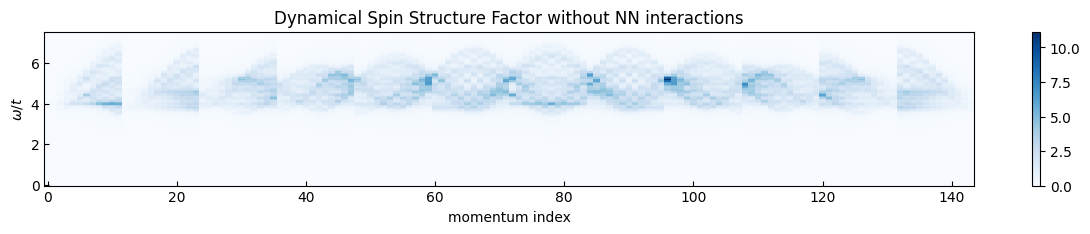

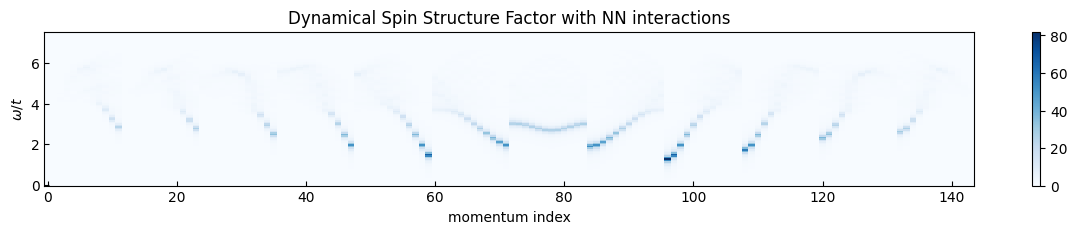

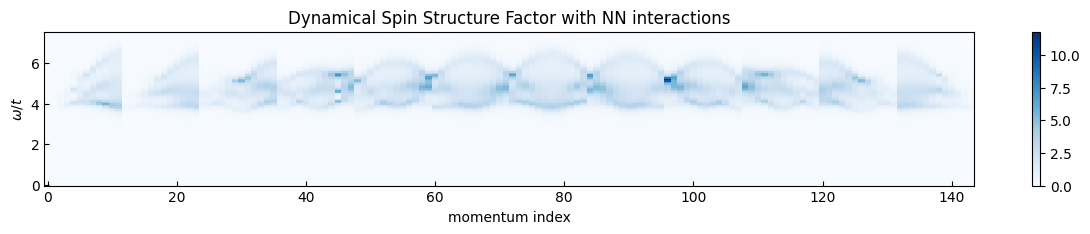

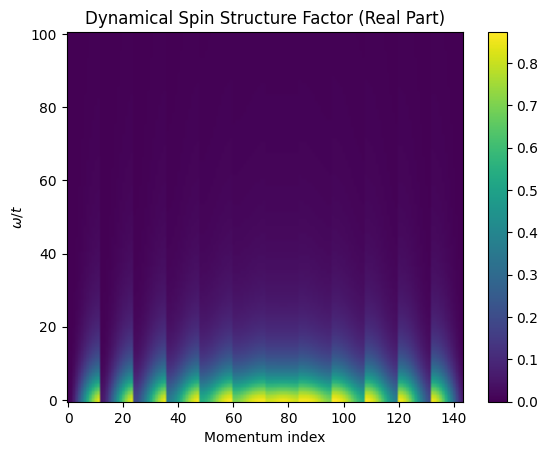

In [6]:
if __name__ == "__main__":
    thet = 0 #np.pi/6 # for gapless Dirac spin liquid choose theta=np.pi/6
    uRPA = 0 # interaction strength in RPA
    j_RPA = 0.35#0.3 # NN interactions from Heisenberg spin-coupling
    j_RPA1 = 0.15
    j_RPA2 = 0.25
    j_RPA3 = 0.30
    j_RPA4 = 0.40
    j_RPA5 = 0.45
    Nuc = 12
    w_steps = 101
    M = 101
    beta=10
    omg_mats = 1j*np.pi*(2*np.arange(1,M+1))/beta

    chi_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=0, thet=thet)
    chi_RPA_tilde, chi_RPA_Pade = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=0, thet=thet)
    chiNN_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA, thet=thet)
    chiNN_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA, thet=thet)
    chiNN1_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA1, thet=thet)
    chiNN1_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA1, thet=thet)
    chiNN2_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA2, thet=thet)
    chiNN2_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA2, thet=thet)
    chiNN3_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA3, thet=thet)
    chiNN3_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA3, thet=thet)
    chiNN4_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA4, thet=thet)
    chiNN4_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA4, thet=thet)
    chiNN5_RPA = run_calculation(Nuc, 7.5, w_steps, eta=1e-1, U_RPA=uRPA, J_RPA=j_RPA5, thet=thet)
    chiNN5_RPA_tilde, A = run_calculation_tilde(Nuc, omg_mats, U_RPA=uRPA, J_RPA=j_RPA5, thet=thet)

    ks = np.arange(Nuc**2)
    ws = np.linspace(0, 7.5, w_steps)

    ks, ws = np.meshgrid(ks, ws)

    fig, ax = pl.subplots(1,1, figsize=(15, 2))

    ###########
    # define dynamical spin struc factor
    ###########
    Z = np.transpose(np.imag(chi_RPA))
    Z_NN_directPade = np.transpose(np.imag(chi_RPA_Pade))
    Z_tildeI = np.transpose(np.imag(chi_RPA_tilde))
    Z_tildeR = np.transpose(np.real(chi_RPA_tilde))
    Z_NN = np.transpose(np.imag(chiNN_RPA))
    Z_NN1 = np.transpose(np.imag(chiNN1_RPA))
    Z_NN2 = np.transpose(np.imag(chiNN2_RPA))
    Z_NN3 = np.transpose(np.imag(chiNN3_RPA))
    Z_NN4 = np.transpose(np.imag(chiNN4_RPA))
    Z_NN5 = np.transpose(np.imag(chiNN5_RPA))
    Z_NN_tildeI = np.transpose(np.imag(chiNN_RPA_tilde))
    Z_NN_tildeR = np.transpose(np.real(chiNN_RPA_tilde))
    ######
    # log scale
    #aa=ax.pcolormesh(ks, ws, Z, cmap='Blues', norm=colors.LogNorm(vmin=1e-2, vmax=100), shading='gouraud')

    # linear scale
    pmesh=ax.pcolormesh(ks, ws, Z, cmap='Blues', vmin=None, vmax=None)#, shading='gouraud')
    fig.colorbar(pmesh, ax=ax, orientation='vertical')
    
    ax.set_ylabel('$\\omega/t$')
    ax.set_xlabel(f'momentum index')
    ######
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    pl.title('Dynamical Spin Structure Factor without NN interactions')
    pl.show()


    fig1, ax = pl.subplots(1,1, figsize=(15, 2))
    # linear scale
    pmesh=ax.pcolormesh(ks, ws, Z_NN, cmap='Blues', vmin=None, vmax=None)
    fig1.colorbar(pmesh, ax=ax, orientation='vertical')
    
    ax.set_ylabel('$\\omega/t$')
    ax.set_xlabel(f'momentum index')
    ######
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    pl.title('Dynamical Spin Structure Factor with NN interactions')
    pl.show()

    fig2, ax = pl.subplots(1,1, figsize=(15, 2))
    # linear scale
    pmesh=ax.pcolormesh(ks, ws, Z_NN_directPade, cmap='Blues', vmin=None, vmax=None)
    fig2.colorbar(pmesh, ax=ax, orientation='vertical')
    pl.title('Dynamical Spin Structure Factor with NN interactions (Direct Pade)')
    ax.set_ylabel('$\\omega/t$')
    ax.set_xlabel(f'momentum index')
    ######
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    pl.title('Dynamical Spin Structure Factor with NN interactions')
    pl.show()


    pl.imshow(Z_tildeR, origin='lower', aspect='auto')
    pl.colorbar()
    pl.xlabel('Momentum index')
    pl.ylabel('$\\omega/t$')
    pl.title('Dynamical Spin Structure Factor (Real Part)')
    pl.show()



In [49]:
import mpmath as mp
mp.mp.dps = 80
def get_PadeApprox1(G_iwn, iWn):
    N = len(G_iwn[0, :])
    L = len(G_iwn[:, 0])
    G_real = np.full((L, 100), None, dtype=complex)
    eta=mp.mpc(1e-1)
    omega_real = np.linspace(0.0, 7.5, 100)+1j*eta*np.ones(100)
    for qq in range(L):
        g = np.full((N, N), None, dtype=complex)
        for m in range(N):
            g[0,m] = mp.mpc(G_iwn[qq, m])
        for i in range(1, N):
            for h in range(i, N):
                if iWn[h] == iWn[i-1] or g[i-1, h] == 0.0:
                    g[i, h] = 0.0
                else:                        
                    g[i, h] = mp.mpc((mp.mpc(g[i-1, i-1]) - mp.mpc(g[i-1, h]))/((mp.mpc(iWn[h]) - mp.mpc(iWn[i-1]))*mp.mpc(g[i-1, h])))
        for l in range(0, 100):
            A = np.zeros(N, dtype=complex)
            B = np.zeros(N, dtype=complex)
            A[0]=0
            B[0]=1
            A[1]=g[0,0]
            B[1]=1
            for n in range(2, N):
                A[n] = mp.mpc(A[n-1]) + (mp.mpc(omega_real[l]) - mp.mpc(iWn[n-1]))*mp.mpc(g[n, n])*mp.mpc(A[n-2])
                B[n] = mp.mpc(B[n-1]) + (mp.mpc(omega_real[l]) - mp.mpc(iWn[n-1]))*mp.mpc(g[n, n])*mp.mpc(B[n-2])
            if np.abs(B[N-1]) == 0.0:
                G_real[qq, l] = 0.0
                print('B[N-1] = 0.0 at qq, l:', qq, l)
            else:
                G_real[qq, l] = mp.mpc(A[N-1])/(mp.mpc(B[N-1]))
    return G_real


In [50]:
def get_PadeApprox2(G_iwn, iWn):
    N = len(G_iwn[0, :])
    L = len(G_iwn[:, 0])
    G_real = np.full((L, 100), None, dtype=complex)
    eta=1e-1
    omega_real = np.linspace(0.0, 7.5, 100)+1j*eta*np.ones(100)
    for qq in range(L):
        g = np.full((N, N), None, dtype=complex)
        for m in range(N):
            g[0,m] = G_iwn[qq, m]
        for i in range(1, N):
            for h in range(i, N):
                if iWn[h] == iWn[i-1] or g[i-1, h] == 0.0:
                    g[i, h] = 0.0
                else:                        
                    g[i, h] = (g[i-1, i-1] - g[i-1, h])/((iWn[h] - iWn[i-1])*g[i-1, h])
        for l in range(0, 100):
            A = np.zeros(N, dtype=complex)
            B = np.zeros(N, dtype=complex)
            A[0]=0
            B[0]=1
            A[1]=g[0,0]
            B[1]=1
            for n in range(2, N):
                A[n] = A[n-1] + (omega_real[l] - iWn[n-1])*g[n, n]*A[n-2]
                B[n] = B[n-1] + (omega_real[l] - iWn[n-1])*g[n, n]*B[n-2]
            if np.abs(B[N-1]) == 0.0:
                G_real[qq, l] = 0.0
                print('B[N-1] = 0.0 at qq, l:', qq, l)
            else:
                G_real[qq, l] = A[N-1]/B[N-1]
    return G_real

In [7]:
#Another Pade algorithm, with reciprocal matrix approach

def get_Xmat(G_iwn, iWn):
    G_iwn = np.asarray(G_iwn, dtype=np.complex128)   # preserve complex
    iWn   = np.asarray(iWn,   dtype=np.complex128)

    L, N  = G_iwn.shape
    half  = N // 2 
    X     = np.ones((L, N, N), dtype=np.complex128)
    SIGMA = np.empty((L, N),   dtype=np.complex128)

    # Precompute powers: P[i, j] = (iWn[i])**j
    P = np.power.outer(iWn, np.arange(N, dtype=int))   # shape (N, N)
    exp_sigma = 1 + N // 2 
    
    for pp in range(L):
        SIGMA[pp, :] = G_iwn[pp, :] * P[:, exp_sigma]
        X[pp, :, 1:half] = P[:, 1:half]
        X[pp, :, half:] = -G_iwn[pp, :, None] * P[:, :N-half]

    return X, SIGMA


# usage
from mpmath import mp

mp.dps = 100

X, SIGMA = get_Xmat(chi_RPA_tilde, omg_mats)
pq = mp.lu_solve(X[90], SIGMA[90])
X_NN, SIGMA_NN = get_Xmat(chiNN_RPA_tilde, omg_mats)
pq_NN = mp.lu_solve(X_NN[90], SIGMA_NN[90])


In [8]:
# usage
X, SIGMA = get_Xmat(chi_RPA_tilde, omg_mats)
X_NN, SIGMA_NN = get_Xmat(chiNN_RPA_tilde, omg_mats)
X_NN1, SIGMA_NN1 = get_Xmat(chiNN1_RPA_tilde, omg_mats)
X_NN2, SIGMA_NN2 = get_Xmat(chiNN2_RPA_tilde, omg_mats)
X_NN3, SIGMA_NN3 = get_Xmat(chiNN3_RPA_tilde, omg_mats)
X_NN4, SIGMA_NN4 = get_Xmat(chiNN4_RPA_tilde, omg_mats)
X_NN5, SIGMA_NN5 = get_Xmat(chiNN5_RPA_tilde, omg_mats)


pq_list = get_pqList(X, SIGMA)
pq_list_NN = get_pqList(X_NN, SIGMA_NN)
pq_list_NN1 = get_pqList(X_NN1, SIGMA_NN1)
pq_list_NN2 = get_pqList(X_NN2, SIGMA_NN2)
pq_list_NN3 = get_pqList(X_NN3, SIGMA_NN3)
pq_list_NN4 = get_pqList(X_NN4, SIGMA_NN4)
pq_list_NN5 = get_pqList(X_NN5, SIGMA_NN5)
print(np.shape(pq_list))

(144, 101)


In [9]:
eTa = 1e-1
OMEGA_real = np.linspace(0.0, 7.5, 101, dtype=np.complex128)+1j*eTa*np.ones(101, dtype=np.complex128)
PADE_TEST = pade_rational_monic(OMEGA_real, pq, 51)
PADE_TEST_NN = pade_rational_monic(OMEGA_real, pq_NN, 51)

PADE_chi_0 = get_PADE3(OMEGA_real, pq_list, 51)
PADE_chi_NN = get_PADE3(OMEGA_real, pq_list_NN, 51)
PADE_chi_NN1 = get_PADE3(OMEGA_real, pq_list_NN1, 51)
PADE_chi_NN2 = get_PADE3(OMEGA_real, pq_list_NN2, 51)
PADE_chi_NN3 = get_PADE3(OMEGA_real, pq_list_NN3, 51)
PADE_chi_NN4 = get_PADE3(OMEGA_real, pq_list_NN4, 51)
PADE_chi_NN5 = get_PADE3(OMEGA_real, pq_list_NN5, 51)

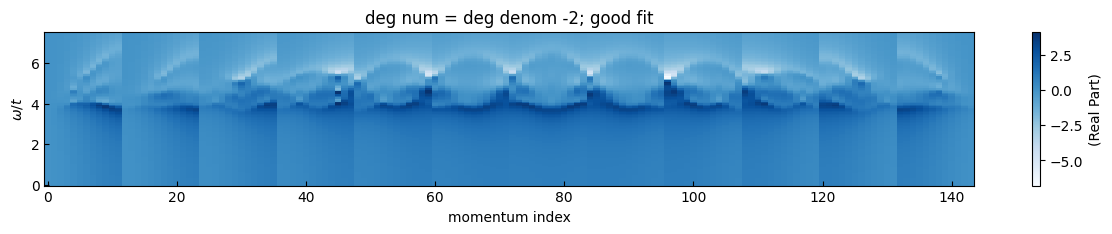

C:\Users\zacha\AppData\Local\Temp\ipykernel_29488\2926180021.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pl.legend()


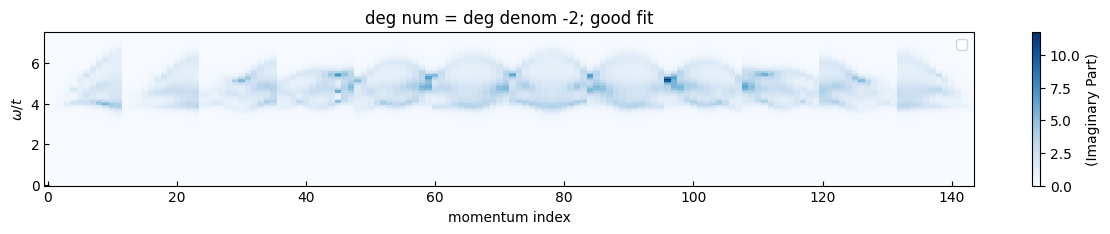

C:\Users\zacha\AppData\Local\Temp\ipykernel_29488\2926180021.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pl.legend()


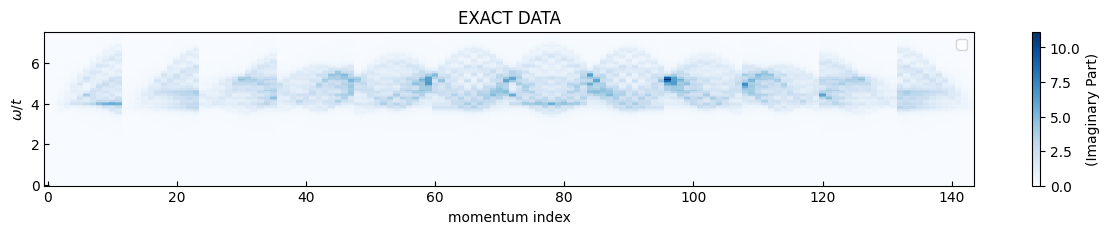

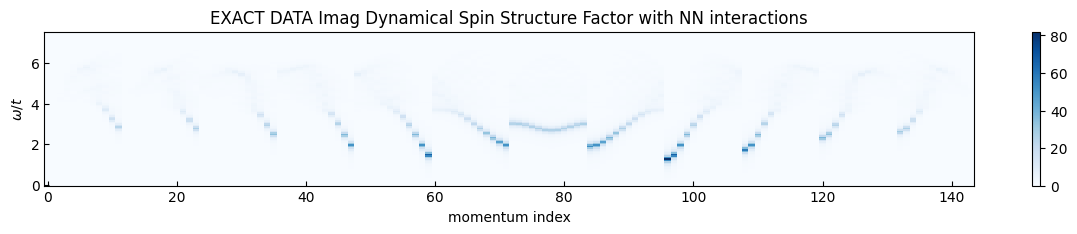

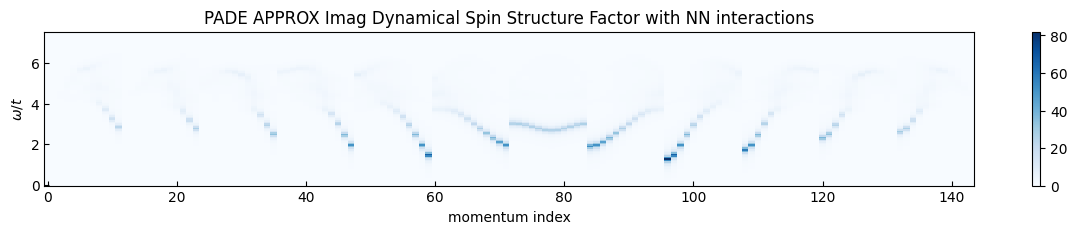

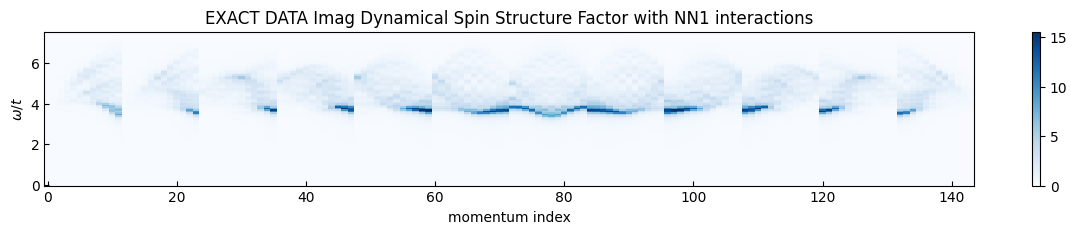

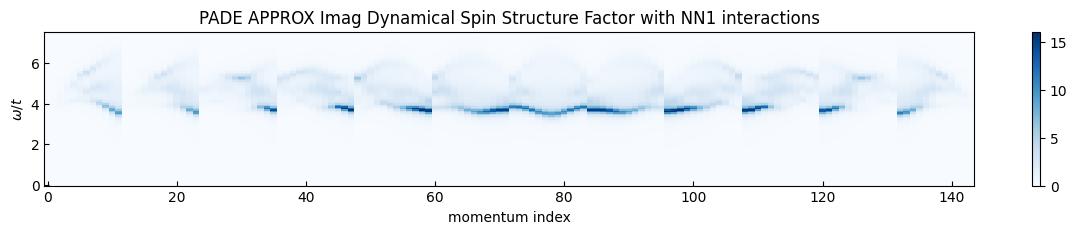

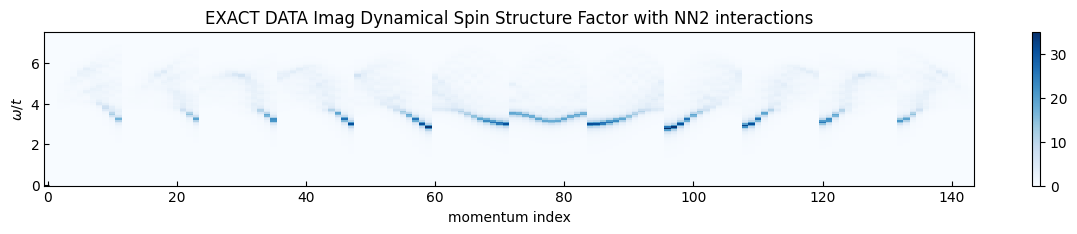

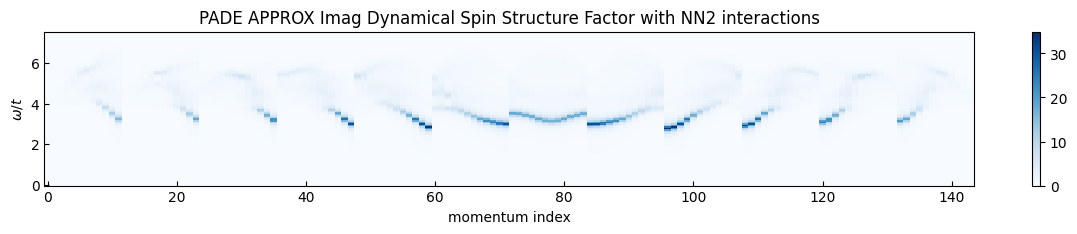

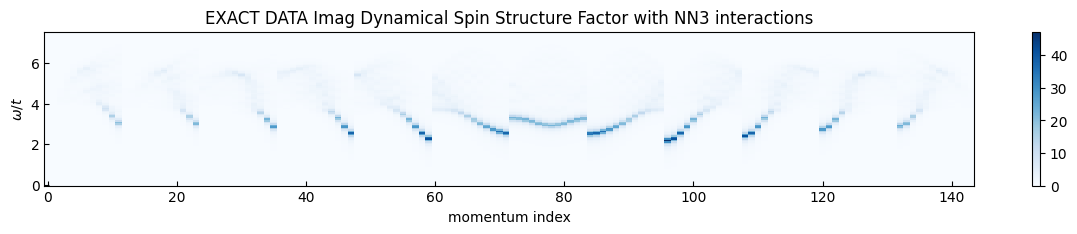

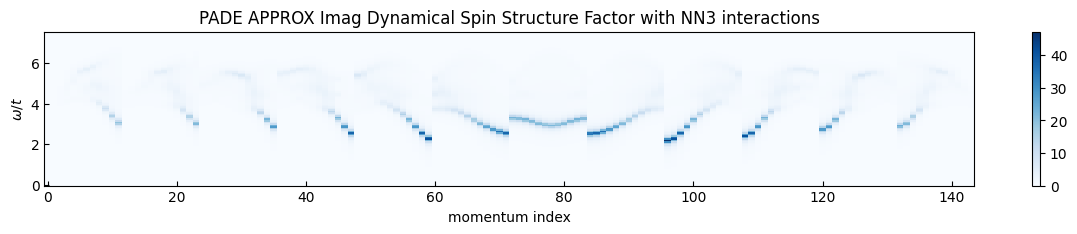

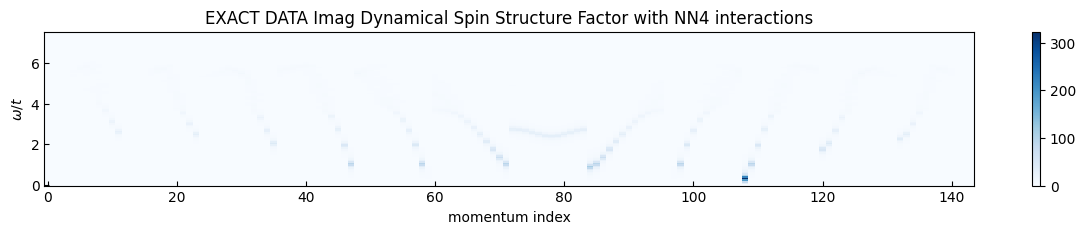

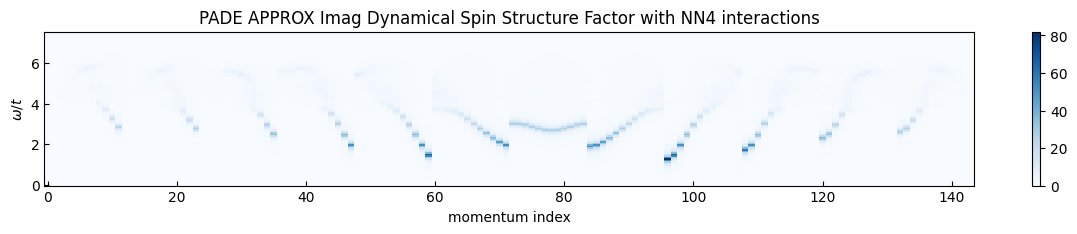

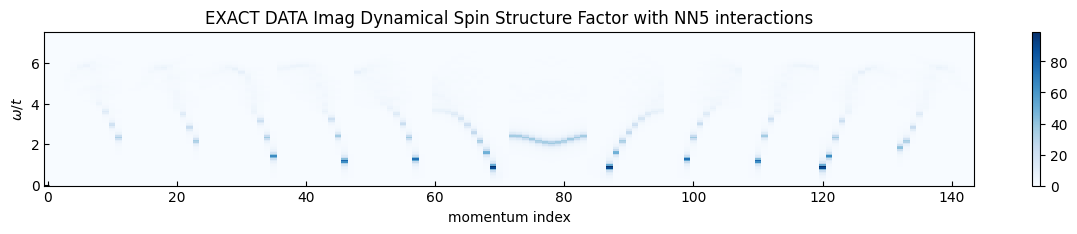

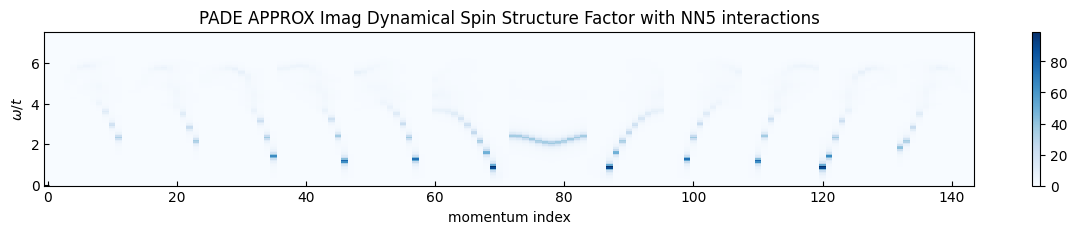

In [11]:
fig1, ax = pl.subplots(1,1, figsize=(15, 2))
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.real(PADE_chi_0)), cmap='Blues', vmin=None, vmax=None)#, shading='gouraud')
fig1.colorbar(pmesh, ax=ax, orientation='vertical', label='(Real Part)')
pl.title('deg num = deg denom -2; good fit')

ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')

pl.show()

fig2, ax = pl.subplots(1,1, figsize=(15, 2), label='pade data imag chi0')
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_0)), cmap='Blues', vmin=None, vmax=None)#, shading='gouraud')
fig2.colorbar(pmesh, ax=ax, orientation='vertical', label='(Imaginary Part)')
pl.title('deg num = deg denom -2; good fit')

ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.legend()
pl.show()

fig3, ax = pl.subplots(1,1, figsize=(15, 2), label='exact data imag chi0')
pmesh=ax.pcolormesh(ks, ws, Z, cmap='Blues', vmin=None, vmax=None)#, shading='gouraud')
fig3.colorbar(pmesh, ax=ax, orientation='vertical', label='(Imaginary Part)')
pl.title('EXACT DATA')

ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.legend()
pl.show()

fig4, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN, cmap='Blues', vmin=None, vmax=None)
fig4.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN interactions')
pl.show()

fig5, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN)), cmap='Blues', vmin=None, vmax=None)
fig5.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN interactions')
pl.show()

fig6, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN1, cmap='Blues', vmin=None, vmax=None)
fig6.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN1 interactions')
pl.show()

fig7, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN1)), cmap='Blues', vmin=None, vmax=None)
fig7.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN1 interactions')
pl.show()

fig8, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN2, cmap='Blues', vmin=None, vmax=None)
fig8.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN2 interactions')
pl.show()

fig9, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN2)), cmap='Blues', vmin=None, vmax=None)
fig9.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN2 interactions')
pl.show()

fig10, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN3, cmap='Blues', vmin=None, vmax=None)
fig10.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN3 interactions')
pl.show()

fig11, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN3)), cmap='Blues', vmin=None, vmax=None)
fig11.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN3 interactions')
pl.show()

fig12, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN4, cmap='Blues', vmin=None, vmax=None)
fig12.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN4 interactions')
pl.show()

fig13, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN)), cmap='Blues', vmin=None, vmax=None)
fig13.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN4 interactions')
pl.show()

fig14, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, Z_NN5, cmap='Blues', vmin=None, vmax=None)
fig14.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('EXACT DATA Imag Dynamical Spin Structure Factor with NN5 interactions')
pl.show()

fig15, ax = pl.subplots(1,1, figsize=(15, 2))
# linear scale
pmesh=ax.pcolormesh(ks, ws, np.transpose(np.imag(PADE_chi_NN5)), cmap='Blues', vmin=None, vmax=None)
fig15.colorbar(pmesh, ax=ax, orientation='vertical')
    
ax.set_ylabel('$\\omega/t$')
ax.set_xlabel(f'momentum index')
######
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
pl.title('PADE APPROX Imag Dynamical Spin Structure Factor with NN5 interactions')
pl.show()

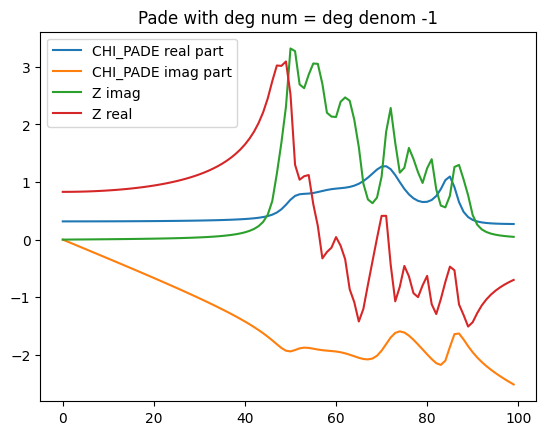

In [ ]:
#Pade with deg num = deg denom -1
pl.plot(np.real(CHI_PADE[90,:]), label='CHI_PADE real part')
pl.plot(np.imag(CHI_PADE[90,:]), label='CHI_PADE imag part')
pl.plot((Z[:,90]), label='Z imag')
pl.plot(np.transpose(np.real(chi_RPA))[:,90], label='Z real')
pl.title("Pade with deg num = deg denom -1")
pl.legend()

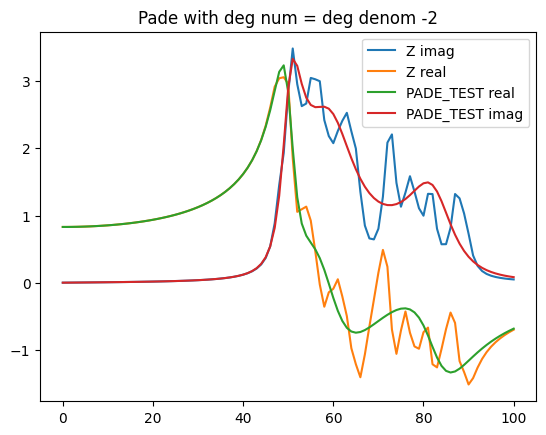

In [ ]:
#Pade with deg num = deg denom -2
pl.plot((Z[:,90]), label='Z imag')
pl.plot(np.transpose(np.real(chi_RPA))[:,90], label='Z real')
pl.plot(np.real(PADE_TEST), label='PADE_TEST real')
pl.plot(np.imag(PADE_TEST), label='PADE_TEST imag')
pl.title("Pade with deg num = deg denom -2")
pl.legend()

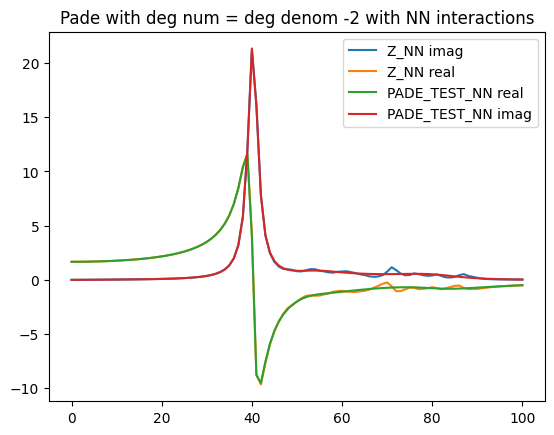

In [62]:
pl.plot((Z_NN[:,90]), label='Z_NN imag')
pl.plot(np.transpose(np.real(chiNN_RPA))[:,90], label='Z_NN real')
pl.plot(np.real(PADE_TEST_NN), label='PADE_TEST_NN real')
pl.plot(np.imag(PADE_TEST_NN), label='PADE_TEST_NN imag')
pl.title("Pade with deg num = deg denom -2 with NN interactions")
pl.legend()
pl.show()
